In [4]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import random
import copy
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm
from two_opt import TwoOpt
from three_opt import ThreeOpt

import elkai
from tsp_solver.greedy import solve_tsp
from python_tsp.exact import solve_tsp_dynamic_programming
import time 


In [5]:
class IDGWO(TwoOpt,ThreeOpt):
    """
    Discrete Grey Wolf-Bat Optimization algorithm
    """

    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        iteration: int,
        num_wolves: int,
        verbose: Optional[bool]):
            
        super().__init__(image,patch_size,verbose)
        self.iteration = iteration
        self.history = {i:[] for i in range(len(self.all_graphs))}
        self.num_wolves = num_wolves

    def initialize(self,n:int,g: Dict[int, Set[int]]) -> List[List[int]]:
        """
        Initialize the initial population of grey wolves

        Arguments:
        n: number of grey wolves

        Return
        initial_population: the initial population of grey wolves
        """
        nodes = sorted(list(g.keys()))
        initial_population = [random.sample(nodes,len(g)) for i in range(n)]
        weight_matrix = self.weight_matrix[nodes][:,nodes]
        # order = solve_tsp(weight_matrix)
        # p_1 = list(np.asarray(nodes)[order])
        # initial_population[0] = p_1

        # LKH

        dm = elkai.DistanceMatrix(weight_matrix)
        order = dm.solve_tsp()
        p_1 = list(np.asarray(nodes)[order[:-1]])
        initial_population[1] = p_1

        return initial_population

    def get_neighbour_rsm_shift(self,route,num_tries):
        """
        Reverse and shifts a segment
        """
        for _ in range(num_tries):
            i = random.randint(0,len(route)-1)
            j = random.randint(i,len(route)-1)
            segment = list(reversed(route[i:j+1]))

            route = route[:i] + route[j+1:]
            k = random.randint(0,len(route))

            route = route[:k] + segment + route[k:]

        return route

    def get_fitness(self,population):
        """
        Gets the fitness of every wolf
        """
        population = population
        fitness = lambda x: self.get_distance(x)

        return list(map(fitness,population))

    def get_distance(self,route):
        return np.sum([self.weight_matrix[route[i],route[i+1]]for i in range(len(route)-1)])
    
    def roulette_wheel(self,population):
        """
        Return either the alpha, beta or delta wolf for mutation
        """

        p = copy.deepcopy(population)
        p = sorted(population, key=lambda x: self.get_distance(x))
        top_3 = [p[0] , p[1], p[2]]
        invert_dist = lambda x : 1/self.get_distance(x)
        top_3_dist = np.asarray(list(map(invert_dist,top_3)))
        top_3_probs = top_3_dist / np.sum(top_3_dist)
        cum_sum = np.cumsum(top_3_probs)
        r = random.random()

        return top_3[(cum_sum > r).tolist().index(1)]

    def rnr(self,distance_matrix,n_iter=10000, init_route = None, init_dropRate=0.8):

        def get_route_distance(distance_matrix, route):
            return np.sum([distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1)])

        def delete_nodes(n:int,route:List[int]) -> Tuple[List[int], List[int]]:
            """
            Remove the nodes from the route
            """
            route = np.asarray(route)
            deleted_index= np.random.choice(range(len(route)), size = n, replace=False)
            deleted_nodes = route[deleted_index]
            broken_route = [node for node in route if node not in deleted_nodes]

            return deleted_nodes,broken_route
        
        def adding_node(route, node, dist_m):
            """
            Add nodes greedily epsilon fashion to the broken path

            route: the broken path
            node: the node to be added into the broken path
            """
            cost = dist_m[route[:-1],node] + dist_m[node,route[1:]] - dist_m[route[:-1],route[1:]]
            index = np.argmin(cost)               
            route = np.insert(route,index+1,node)
            
            return route
        
        if init_route is None:
            best_route = [x for x in range(distance_matrix.shape[0])]
        else:
            best_route = init_route
        
        best_distance = get_route_distance(distance_matrix, best_route)
        last_route = best_route
        dropRate = init_dropRate
        
        for i_iter in range(n_iter):
            drop = distance_matrix.shape[0] // 2
            absent_nodes, current_route = delete_nodes(drop, last_route)
            
            for node in absent_nodes:
                current_route = adding_node(current_route, node, distance_matrix)

            current_distance = get_route_distance(distance_matrix, current_route)
            if current_distance < best_distance:
                best_distance = current_distance
                best_route = current_route
        
        return best_distance, best_route

    def optimize_local(self,distance_matrix, route, n_iter, verbose=False):
        best_route = copy.deepcopy(route) 
        best_distance = self.get_distance(best_route)
        multiple = 2
        route_length = len(best_route)-1
        while route_length>=20:
            i_unchanged = 0
            current_n_iter = n_iter
            
            while i_unchanged < (multiple*2):
                if verbose: 
                    print("Optimizing:", route_length, i_unchanged+1, '/', multiple*2, best_distance)

                s = random.randint(0,route_length//2)
                sub_route = np.array(best_route[s:s+route_length])
                sub_weight_matrix = self.weight_matrix[sub_route][:,sub_route]
                dist, order = self.rnr(sub_weight_matrix, n_iter=current_n_iter)
                improved_sub_route = sub_route[order]
                rnr_route = list(best_route[:s]) + list(improved_sub_route) + list(best_route[s+route_length:])
                rnr_dist = self.get_distance(rnr_route)
                if rnr_dist < best_distance:
                    best_route = rnr_route
                    best_distance = rnr_dist
                    i_unchanged = 0
                else:
                    i_unchanged += 1

                # temp = np.asarray(self.history[0])[-1,:]
                # temp[0] = self.one_path_checker(self.build_path(best_route,self.adj_list,self.local_to_coords))[1]
                # self.history[0].append(temp)

            multiple *= 2
            route_length = route_length // 2

        return best_route

    def _optimize_one(self,i_g, g):
        """
        Optimize according to the discrete grey wolf optimizer
        """
        population = self.initialize(self.num_wolves,g)
        population = sorted(population, key=lambda x: self.get_distance(x))
        best_path = population[0]
        best_path_dist = self.get_distance(population[0])
        for i in tqdm(range(self.iteration)):
            for j in range(3,self.num_wolves):
                d_1 = random.randint(0, int(distance.hamming(population[0],population[j]) * len(g)))
                d_2 = random.randint(0, int(distance.hamming(population[1],population[j]) * len(g)))
                d_3 = random.randint(0, int(distance.hamming(population[2],population[j]) * len(g)))
                    
                d = (d_1+d_2+d_3) // 3
                if random.random() > i/self.iteration:
                    wolf = self.roulette_wheel(population)
                    population[j] = self.get_neighbour_rsm_shift(wolf,max(1,d//(i+1)))

                population[j] = self.two_opt(population[j])
                population[j] = self.optimize_local(self.weight_matrix,population[j],1)

            """
            This section is for statistics purposes
            """
            # all_fitness = self.get_fitness(population)
            all_fitness = [self.one_path_checker(self.build_path(path,self.adj_list,self.local_to_coords))[1] for path in population]

            self.history[i_g].append(all_fitness)

            """
            Optimization continues here
            
            """
            population = sorted(population, key=lambda x: self.get_distance(x))
            next_best_path_dist = self.get_distance(population[0])
            if best_path_dist > next_best_path_dist:
                best_path = population[0]
                best_path_dist = next_best_path_dist

        return best_path
        
    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []   
        for i, g in enumerate(self.all_graphs):
            path = self._optimize_one(i,g)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p
        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)
            self.all_path_converted = []        

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[-1])

            return path


Preprocessing of graph completed
114


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


[1440, 1500, 1501, 1441, 1442, 1443, 1383, 1384, 1444, 1445, 1385, 1386, 1387, 1388, 1389, 1449, 1450, 1390, 1391, 1451, 1452, 1512, 1513, 1453, 1454, 1514, 1454, 1394, 1395, 1455, 1456, 1396, 1397, 1457, 1458, 1398, 1399, 1400, 1460, 1461, 1401, 1402, 1462, 1463, 1464, 1404, 1403, 1404, 1405, 1345, 1346, 1406, 1346, 1347, 1348, 1288, 1287, 1288, 1228, 1229, 1289, 1290, 1230, 1231, 1291, 1292, 1232, 1233, 1293, 1294, 1295, 1235, 1175, 1174, 1234, 1235, 1236, 1296, 1297, 1237, 1238, 1298, 1299, 1239, 1240, 1300, 1301, 1241, 1242, 1302, 1303, 1304, 1305, 1306, 1366, 1367, 1307, 1308, 1309, 1310, 1250, 1251, 1311, 1312, 1252, 1253, 1313, 1314, 1315, 1314, 1374, 1375, 1376, 1316, 1317, 1377, 1378, 1379, 1439, 1438]
0 192 464 184
(120, 6, 0)
Average time = 56.11319891200401


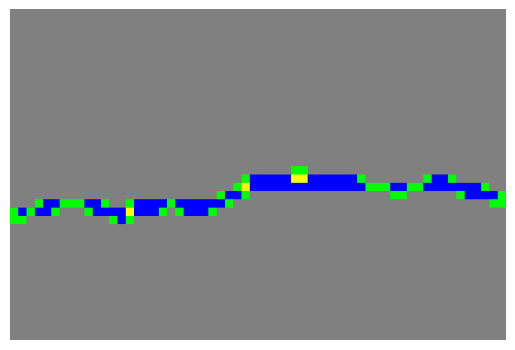

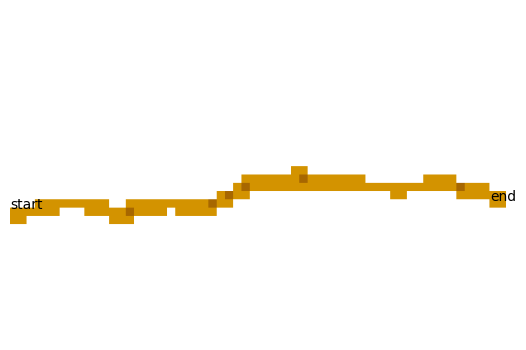

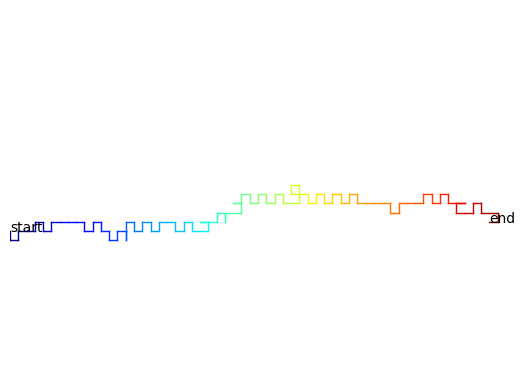

In [6]:
if __name__ == "__main__":
    num_runs = 1
    start_time = time.perf_counter()
    for i in range(num_runs):
        img = cv2.imread("./binary_image/4.png",cv2.IMREAD_UNCHANGED) 
        # img = cv2.imread("./all_cracks/Train/masks/DeepCrack_11123-2.jpg")
        # img = cv2.imread("./val_gt/val_gt/01460.png")
        if len(img.shape) == 3:
            img = np.any(img > 0, axis=-1)

        ps = (8,8)
        x = IDGWO(img,ps,50,20,False)
        print(x.num_vertex)
        path = x._optimize()
        print(path)
        print(x.check_all_path())
        # x.get_statistics("Improved Discrete Grey Wolf",20,x.history)
        x.draw_path()

    end_time = time.perf_counter()
    print(f"Average time = {(end_time - start_time)/num_runs}")
